# Supervised Fine-Tuning (SFT): Full Parameter Training

This notebook performs a **full fine-tuning** of the base `gpt2` model. All of the model's parameters are updated during training on our custom instruction dataset.

### **Objective:**
- Create a powerful, specialized model by training the entire network.
- Establish a high-performance benchmark to compare against more efficient methods.

In [2]:
# !pip install transformers==4.43.4
# !pip install torch
# # !pip install trl
# !pip install trl==0.11
# !pip install peft
# !pip install --upgrade tqdm
# !pip install --upgrade jinja2

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
from peft import LoraConfig
from trl import SFTTrainer

In [2]:
from prepare_data import get_sft_datasets

In [3]:
train_dataset, test_dataset = get_sft_datasets(dataset_name='my-local-dataset/')

Loading and processing dataset
Dataset split into 31485 training examples and 1658 testing examples.
Dataset processing complete.


In [12]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')

In [13]:
def add_eos_token(sample):
    sample["completion"] = sample["completion"] + tokenizer.eos_token
    return sample

In [14]:
train_dataset = train_dataset.map(add_eos_token)
test_dataset = test_dataset.map(add_eos_token)

In [15]:
print("\n--- Train Set Verification ---")
print(f"Train dataset size: {len(train_dataset)} examples")
print("Features:", train_dataset.features)
print("\nPROMPT:", train_dataset[0]['prompt'])
print("COMPLETION:", train_dataset[0]['completion'])
    
print("\n--- Test Set Verification ---")
print(f"Test dataset size: {len(test_dataset)} examples")
print("Features:", test_dataset.features)
print("\nPROMPT:", test_dataset[0]['prompt'])
print("COMPLETION:", test_dataset[0]['completion'])


--- Train Set Verification ---
Train dataset size: 31485 examples
Features: {'prompt': Value(dtype='string', id=None), 'completion': Value(dtype='string', id=None)}

PROMPT: ### Instruction:
What are some tips for developing a better mental attitude towards difficult tasks.

### Response:

COMPLETION: Break difficult tasks down into manageable pieces. 
2. Take things one step at a time and reward yourself for small accomplishments. 
3. Visualize yourself succeeding in the task. 
4. Focus on the process rather than the outcome. 
5. Remind yourself that you are capable of completing the task.
6. Believe in yourself and your ability to find new solutions to problems. 
7. Give yourself positive affirmations and build a positive mindset.
8. Eliminate distractions and prioritize meaningful tasks. 
9. Take time to refocus and regroup when necessary. 
10. Surround yourself with positive people who will help you stay focused on your goals.<|endoftext|>

--- Test Set Verification ---
Test datas

In [16]:
train_dataset

Dataset({
    features: ['prompt', 'completion'],
    num_rows: 31485
})

In [17]:
test_dataset

Dataset({
    features: ['prompt', 'completion'],
    num_rows: 1658
})

In [18]:
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

CUDA available: True
GPU count: 1
GPU name: NVIDIA A10G


In [19]:
# Model and tokenizer names
model_name = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token 

In [20]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
)
model.config.use_cache = False # Disable caching for training

In [21]:
training_args = TrainingArguments(
    output_dir="./full_sft_results",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    optim="adamw_torch",     
    learning_rate=2e-5,      
    fp16=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    logging_steps=50,
    logging_first_step=True,
    eval_strategy="steps",      
    eval_steps=500,             
    save_steps=500,             
    save_total_limit=2,         
    load_best_model_at_end=True
)

In [23]:
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    args=training_args,
    max_seq_length=1024,
)

##  Start training

In [24]:
trainer.train()

Step,Training Loss,Validation Loss
500,1.965800,1.850789
1000,1.925900,1.796923
1500,1.879000,1.763775
2000,1.813800,1.741225
2500,1.781300,1.727432
3000,1.754900,1.711965
3500,1.750500,1.698856
4000,1.702700,1.688667
4500,1.687700,1.682476
5000,1.697400,1.673320


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=5904, training_loss=1.7994211636746156, metrics={'train_runtime': 1343.5866, 'train_samples_per_second': 70.301, 'train_steps_per_second': 4.394, 'total_flos': 8479227026304000.0, 'train_loss': 1.7994211636746156, 'epoch': 3.0})

In [25]:
trainer.save_model("./full_sft_final_checkpoint")
tokenizer.save_pretrained("./full_sft_final_checkpoint")

('./full_sft_final_checkpoint/tokenizer_config.json',
 './full_sft_final_checkpoint/special_tokens_map.json',
 './full_sft_final_checkpoint/vocab.json',
 './full_sft_final_checkpoint/merges.txt',
 './full_sft_final_checkpoint/added_tokens.json',
 './full_sft_final_checkpoint/tokenizer.json')

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\nLoading base gpt2 model...")
base_model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
base_tokenizer = AutoTokenizer.from_pretrained("gpt2")

print("Loading FULL SFT model...")
sft_model = AutoModelForCausalLM.from_pretrained("./full_sft_final_checkpoint/").to(device)
sft_tokenizer = AutoTokenizer.from_pretrained("./full_sft_final_checkpoint/")


Loading base gpt2 model...
Loading FULL SFT model...


In [80]:
def generate_response(model, tokenizer, prompt_text):
    """
    Generates a response from a given model and tokenizer.
    """
    
    formatted_prompt = f"### Instruction:\n{prompt_text}\n\n### Response:\n"
    
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=250,
            temperature=0.6,  
            do_sample=True, 
            repetition_penalty=1.2
        )
    
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return full_response[len(formatted_prompt):].strip()

In [81]:
def evaluate_models(prompt, ground_truth, models):
    print("\n" + "="*100)
    print(" PERFORMANCE COMPARISON ".center(100, "="))
    print("="*100)

    print(f"\nPROMPT:\n{prompt}\n")
    print('-'*100)
    print(f"GROUND TRUTH:\n{ground_truth}\n")

    for name, model, tokenizer in models:
        print("-"*100)
        print(f"\n--- {name.upper()} RESPONSE ---")
        response = generate_response(model, tokenizer, prompt)
        print(response)

In [82]:
models_to_compare = [
    ("Base Model (GPT-2)", base_model, base_tokenizer),
    ("FULL SFT Model", sft_model, sft_tokenizer),
]

In [83]:
idx = 10
prompt = test_dataset[idx]["prompt"]
ground_truth = test_dataset[idx]["completion"]


evaluate_models(prompt, ground_truth, models_to_compare)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



====================================== PERFORMANCE COMPARISON ======================================

PROMPT:
### Instruction:
What is the best way to clean and care for leather shoes.

### Response:


----------------------------------------------------------------------------------------------------
GROUND TRUTH:
The best way to clean and care for leather shoes is to start by using a leather cleaner specifically designed for the type of leather used. This will not only help keep them clean, but also help protect the leather from the elements. Once cleaned, apply a leather conditioner to help keep the leather soft and supple. Finally, use a leather polish to help add luster and protection. Reapply the products every couple of months to keep your shoes looking their best.<|endoftext|>

----------------------------------------------------------------------------------------------------

--- BASE MODEL (GPT-2) RESPONSE ---


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The material provided in this post was not created by me or any of my employees, nor does it represent an endorsement by Nike (or anyone else). The materials are made out with extreme caution as they do contain a wide range available from both regular high quality fabrics such 2X3s that can be used on your footwear without ever being exposed to moisture due over time but you should always wear protective clothing when using these types if possible while working at work - check our "Safety Tips" section below
----------------------------------------------------------------------------------------------------

--- FULL SFT MODEL RESPONSE ---
The best method of cleaning and caringfor a Leather Shoes is to use an antibacterial soap made from natural fibers such as cotton, linen or wool for several days a week. This will help prevent the leathers from becoming scratched or stained. Additionally it can be helpful in brushing your feet with some mild dish soap before washing them regularly so

In [84]:
idx = 20
prompt = test_dataset[idx]["prompt"]
ground_truth = test_dataset[idx]["completion"]


evaluate_models(prompt, ground_truth, models_to_compare)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



====================================== PERFORMANCE COMPARISON ======================================

PROMPT:
### Instruction:
I want to shop for a new car. What should I look for in price, features, and safety.

### Response:


----------------------------------------------------------------------------------------------------
GROUND TRUTH:
For price, look for a car that fits your budget. Consider the total cost, including maintenance, registration, and insurance. When it comes to features, think about what is most important to you. Do you need a lot of cargo space? Or are you looking for the latest technology? When it comes to safety, look for a car with the latest safety features, like lane-keeping assist, adaptive cruise control, and blind spot monitoring. Additionally, consider the car’s ratings in crash tests and look for features like airbags, anti-lock brakes, and anti-theft systems.<|endoftext|>

--------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


There are 3 options available here that will help you choose the right vehicle based on your needs.: 1.) The best option is our 6 speed manual transmission (2WD) or 2). This may be better if it has an EPA rating than other choices such as those offered by BMW Group of America.(3)."If there's any question about which model would fit my requirements," says Richard Kresser,, "the answer depends upon what type/specification we're looking at."The 5-speed automatic transmissions come with no brakes while they have all their independent parts installed so this way customers can get into control without having them move around uncontrollably during driving.�So how do these cars compare?�We'll say one thing immediately when someone points out some differences between different models but before going further please read through each part separately from others below:"You need 4 tires plus front wheels.""Which engine does driver prefer?""Ford Fusions""Sterling SVT 830 Turbo Diesel".And lastly...

In [67]:
import json
import matplotlib.pyplot as plt

log_file = "full_sft_results/checkpoint-5904/trainer_state.json"

# Read the log file
with open(log_file, 'r') as f:
    logs = json.load(f)

# --- Prepare lists to store all metrics ---
train_steps = []
train_losses = []
eval_steps = []
eval_losses = []

# --- Iterate through the log history and extract all data ---
for log in logs["log_history"]:
    if "loss" in log:
        train_steps.append(log["step"])
        train_losses.append(log["loss"])
    
    elif "eval_loss" in log:
        eval_steps.append(log["step"])
        eval_losses.append(log["eval_loss"])

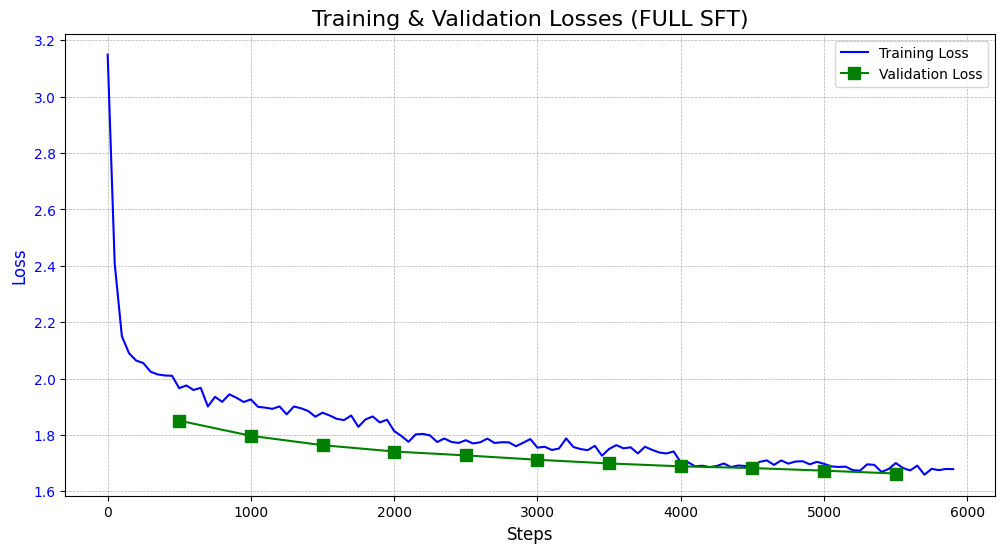

In [69]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(train_steps, train_losses, 'b-', label="Training Loss")
ax1.plot(eval_steps, eval_losses, 'g-s', label="Validation Loss", markersize=8) 
ax1.set_xlabel("Steps", fontsize=12)
ax1.set_ylabel("Loss", color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.title("Training & Validation Losses (FULL SFT)", fontsize=16)

lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper right')

plt.show()

### Rouge Score

In [4]:
from tqdm import tqdm
import numpy as np
import logging
from transformers import logging as transformers_logging
transformers_logging.set_verbosity_error()

### Full SFT Model Performance

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model_name = "gpt2"
full_sft_checkpoint = "./full_sft_final_checkpoint/"

tokenizer = AutoTokenizer.from_pretrained(base_model_name, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token

In [6]:
base_model = AutoModelForCausalLM.from_pretrained(base_model_name).to(device)
base_model.eval()
sft_model = AutoModelForCausalLM.from_pretrained(full_sft_checkpoint).to(device)
sft_model.eval()
print("Models loaded successfully!")

Models loaded successfully!


In [7]:
predictions = []
references = []

print("\nGenerating predictions on the test set...")

batch_size = 16
for i in tqdm(range(0, len(test_dataset), batch_size)):
    batch = test_dataset[i:i+batch_size]
    prompts = batch['prompt']
    ground_truths = batch['completion']
    
    # Tokenize prompts
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    
    with torch.no_grad():
        outputs = sft_model.generate(
            **inputs,
            max_new_tokens=100,
            num_beams=3,
            temperature=0.6,
            do_sample=False,
            repetition_penalty=1.2
        )
    
    # Decode and clean up the generated text
    decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    
    # Remove the original prompt from the generated text
    cleaned_predictions = [out[len(prompt):].strip() for out, prompt in zip(decoded_outputs, prompts)]
    
    # Add to lists
    predictions.extend(cleaned_predictions)
    references.extend(ground_truths)


Generating predictions on the test set...


100%|██████████| 104/104 [02:57<00:00,  1.70s/it]


In [8]:
print(len(predictions))
print(len(references))

1658
1658


In [9]:
print(predictions[0])

The different types of loans you can apply for to purchase a house include fixed-rate mortgages, adjustable-rate mortgages, variable-rate mortgages, and home equity loans. Each type of loan has its own set of terms and conditions, so it is important to understand the different types of loans before making any decisions. Additionally, it is important to research the different types of loans before making any decisions. Finally, it is important to review the terms and conditions of each loan before making any decisions.


In [10]:
print(references[0])

Conventional Loans  
			2  FHA Loans  
			3  VA Loans 
			4  USDA Loans 
			5  Home Equity Loans 
			6  Balloon Mortgages 
			7  Adjustable Rate Mortgages (ARMs) 
			8  Jumbo Mortgage Loans.


In [11]:
# !pip install rouge_score

In [12]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

all_scores = []
for ref, pred in zip(references, predictions):
    score = scorer.score(ref, pred)
    all_scores.append(score)

In [13]:
all_scores[0]

{'rouge1': Score(precision=0.1511627906976744, recall=0.48148148148148145, fmeasure=0.23008849557522124),
 'rouge2': Score(precision=0.047058823529411764, recall=0.15384615384615385, fmeasure=0.07207207207207207),
 'rougeL': Score(precision=0.08139534883720931, recall=0.25925925925925924, fmeasure=0.12389380530973454)}

In [14]:
rouge1 = [s["rouge1"].fmeasure for s in all_scores]
rouge2 = [s["rouge2"].fmeasure for s in all_scores]
rougeL = [s["rougeL"].fmeasure for s in all_scores]

print("ROUGE-1:", np.mean(rouge1))
print("ROUGE-2:", np.mean(rouge2))
print("ROUGE-L:", np.mean(rougeL))

ROUGE-1: 0.35344826914040317
ROUGE-2: 0.14871991893327755
ROUGE-L: 0.2621895897977325


### Base Model Performance

In [15]:
base_predictions = []
base_references = []

print("\nGenerating predictions on the test set...")

batch_size = 16
for i in tqdm(range(0, len(test_dataset), batch_size)):
    batch = test_dataset[i:i+batch_size]
    prompts = batch['prompt']
    ground_truths = batch['completion']
    
    # Tokenize prompts
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    
    # Generate predictions
    with torch.no_grad():
        outputs = base_model.generate(
            **inputs,
            max_new_tokens=100,
            num_beams=3,
            temperature=0.6,
            do_sample=False,
            repetition_penalty=1.2
        )
    
    # Decode and clean up the generated text
    decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    
    # Remove the original prompt from the generated text
    cleaned_predictions = [out[len(prompt):].strip() for out, prompt in zip(decoded_outputs, prompts)]
    
    # Add to lists
    base_predictions.extend(cleaned_predictions)
    base_references.extend(ground_truths)


Generating predictions on the test set...


100%|██████████| 104/104 [02:56<00:00,  1.70s/it]


In [16]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

all_scores = []
for ref, pred in zip(base_references, base_predictions):
    score = scorer.score(ref, pred)
    all_scores.append(score)

In [17]:
rouge1 = [s["rouge1"].fmeasure for s in all_scores]
rouge2 = [s["rouge2"].fmeasure for s in all_scores]
rougeL = [s["rougeL"].fmeasure for s in all_scores]

print("ROUGE-1:", np.mean(rouge1))
print("ROUGE-2:", np.mean(rouge2))
print("ROUGE-L:", np.mean(rougeL))

ROUGE-1: 0.17926610018962283
ROUGE-2: 0.049183680182620836
ROUGE-L: 0.144408105417299


    Metric	Base Model Score  	SFT Model Score   	Improvement
    ROUGE-1	17.93	            35.34	                    +97.1%
    ROUGE-2	4.92    	        14.87                       +202.2%
    ROUGE-L	14.44	           26.22	                     +81.6%

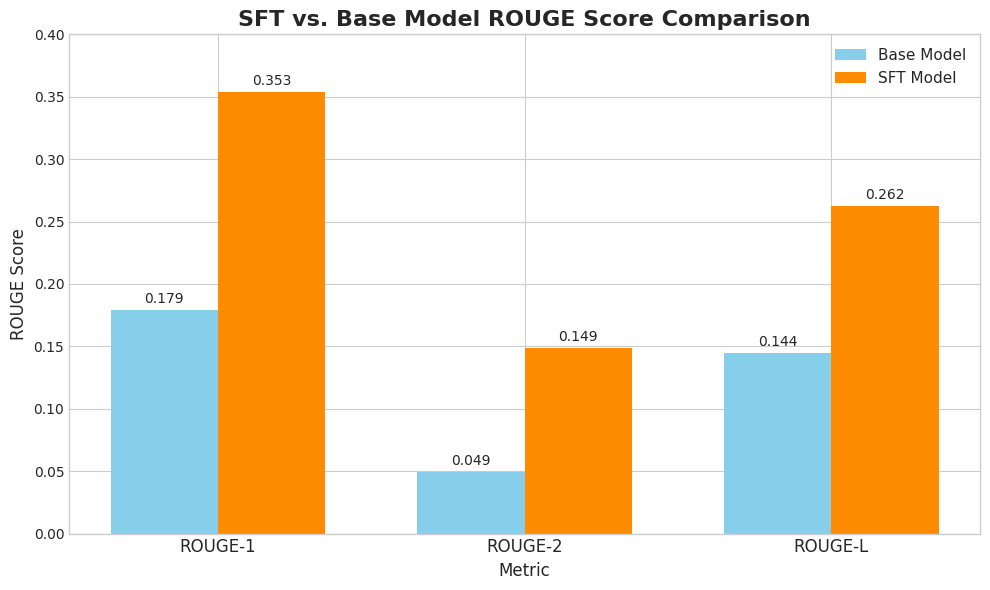

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = {
    "Metric": ["ROUGE-1", "ROUGE-2", "ROUGE-L"],
    "Base Model": [0.1792, 0.0491, 0.1444],
    "SFT Model": [0.3534, 0.1487, 0.2621]
}
df = pd.DataFrame(data)
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(df['Metric']))
width = 0.35  

rects1 = ax.bar(x - width/2, df['Base Model'], width, label='Base Model', color='skyblue')
rects2 = ax.bar(x + width/2, df['SFT Model'], width, label='SFT Model', color='darkorange')

ax.set_ylabel('ROUGE Score', fontsize=12)
ax.set_xlabel('Metric', fontsize=12)
ax.set_title('SFT vs. Base Model ROUGE Score Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df['Metric'], fontsize=12)
ax.legend(fontsize=11)
ax.set_ylim(0, 0.4) 


ax.bar_label(rects1, padding=3, fmt='%.3f', fontsize=10)
ax.bar_label(rects2, padding=3, fmt='%.3f', fontsize=10)


fig.tight_layout()
plt.show()

In [42]:
import os
os.chdir('..')

In [43]:
os.makedirs("outputs", exist_ok=True)

### PEFT SFT Model Performance

In [37]:
base_model_name = "SFT/gpt2"
peft_sft_checkpoint = "./SFT/peft_sft_final_checkpoint_2/"

base_model = AutoModelForCausalLM.from_pretrained(base_model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(base_model_name, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token

In [38]:
from peft import PeftModel
peft_sft_model = PeftModel.from_pretrained(base_model, peft_sft_checkpoint)
peft_sft_model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPT2LMHeadModel(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 768)
        (wpe): Embedding(1024, 768)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-11): 12 x GPT2Block(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2SdpaAttention(
              (c_attn): lora.Linear(
                (base_layer): Conv1D()
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2304, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lo

In [39]:
peft_predictions = []
peft_references = []

print("\nGenerating predictions on the test set...")

batch_size = 16
for i in tqdm(range(0, len(test_dataset), batch_size)):
    batch = test_dataset[i:i+batch_size]
    prompts = batch['prompt']
    ground_truths = batch['completion']
    
    # Tokenize prompts
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    
    with torch.no_grad():
        outputs = peft_sft_model.generate(
            **inputs,
            max_new_tokens=100,
            num_beams=3,
            temperature=0.6,
            do_sample=False,
            repetition_penalty=1.2
        )
    
    # Decode and clean up the generated text
    decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    
    # Remove the original prompt from the generated text
    cleaned_predictions = [out[len(prompt):].strip() for out, prompt in zip(decoded_outputs, prompts)]
    
    # Add to lists
    peft_predictions.extend(cleaned_predictions)
    peft_references.extend(ground_truths)


Generating predictions on the test set...


100%|██████████| 104/104 [03:10<00:00,  1.83s/it]


In [40]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

all_scores = []
for ref, pred in zip(peft_references, peft_predictions):
    score = scorer.score(ref, pred)
    all_scores.append(score)

In [41]:
rouge1 = [s["rouge1"].fmeasure for s in all_scores]
rouge2 = [s["rouge2"].fmeasure for s in all_scores]
rougeL = [s["rougeL"].fmeasure for s in all_scores]

print("ROUGE-1:", np.mean(rouge1))
print("ROUGE-2:", np.mean(rouge2))
print("ROUGE-L:", np.mean(rougeL))

ROUGE-1: 0.3117310002930892
ROUGE-2: 0.12603219237194924
ROUGE-L: 0.2405275465875746


In [48]:
import json

with open("outputs/base_outputs.json", "w") as f:
    json.dump({
        "predictions": base_predictions,
        "references": base_references
    }, f, indent=4)
    
    
with open("outputs/full_sft_outputs.json", "w") as f:
    json.dump({
        "predictions": predictions,
        "references": references
    }, f, indent=4)
    
with open("outputs/peft_sft_outputs.json", "w") as f:
    json.dump({
        "predictions": peft_predictions,
        "references": peft_references
    }, f, indent=4)

In [54]:
# Data for the three models
data = {
    "Metric": ["ROUGE-1", "ROUGE-2", "ROUGE-L"],
    "Base Model": [0.1793, 0.0492, 0.1444],
    "Full SFT": [0.3534, 0.1487, 0.2622],
    "PEFT SFT": [0.3117, 0.1260, 0.2405]
}
df = pd.DataFrame(data)

# --- 1. Save the metrics to a CSV file ---
csv_filename = 'sft_performance_metrics.csv'
df.to_csv(csv_filename, index=False, float_format='%.4f')
print(f"Metrics saved to {csv_filename}")

fig, ax = plt.subplots(figsize=(12, 7))

# Set bar positions and width for three groups
x = np.arange(len(df['Metric']))
width = 0.25

# Plot the bars for each model
rects1 = ax.bar(x - width, df['Base Model'], width, label='Base Model', color='lightcoral')
rects2 = ax.bar(x, df['Full SFT'], width, label='Full SFT', color='cornflowerblue')
rects3 = ax.bar(x + width, df['PEFT SFT'], width, label='PEFT SFT', color='mediumseagreen')

# Add labels, title, and ticks
ax.set_ylabel('ROUGE Score', fontsize=12)
ax.set_xlabel('Metric', fontsize=12)
ax.set_title('SFT Performance Comparison: Full vs. PEFT', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df['Metric'], fontsize=12)
ax.legend(fontsize=11)
ax.set_ylim(0, 0.45)

# Add data labels on top of each bar
ax.bar_label(rects1, padding=3, fmt='%.3f', fontsize=9)
ax.bar_label(rects2, padding=3, fmt='%.3f', fontsize=9)
ax.bar_label(rects3, padding=3, fmt='%.3f', fontsize=9)

# Final layout adjustments and save the figure
fig.tight_layout()
plot_filename = "sft_vs_peft_comparison.png"
plt.savefig(plot_filename)

Metrics saved to sft_performance_metrics.csv
